In [ ]:
import pickle
import pandas as pd
import json
import pprint
from tqdm import tqdm
import numpy as np
import os
import sys

In [2]:
from adr import adr

In [ ]:
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.representation import MaximalMarginalRelevance
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.backend._sentencetransformers import SentenceTransformerBackend

In [ ]:
# This is a dictionary with all the details of the ADRs, with a hierarchical organization
# that goes from the organization to its projects and finally the ADR files inside each project
ENGLISH_DATAPATH = './data/LLM4ADR-adrs__adrs_english.pickle' 

TOPIC_FOLDER = "saved_topicmodel"

In [7]:
with open(ENGLISH_DATAPATH,'rb') as file:
    dict_adrs = pickle.load(file)
print(len(dict_adrs), "projects/organizations?")

547 projects/organizations?


In [ ]:
# Check projects and ADRs and filter out those that do not have enough ADRs or ADRs that are too short
min_adrs_per_project = 5
min_adr_length = 500

valid_projects = set()
filtered_projects = set()
all_projects = set()
for org in tqdm(dict_adrs, "organizations"): 
    for project in dict_adrs[org]:
        all_projects.add((org, project))
        # print(dict_adrs[org][project].keys())
        if len(dict_adrs[org][project]) < min_adrs_per_project:
            filtered_projects.add((org, project))
            continue
        valid = 0
        for adr_ in dict_adrs[org][project]: 
            s = dict_adrs[org][project][adr_].get_content_no_code_str()
            if (len(s) >= min_adr_length) and not s.isspace() :
                valid += 1
        if valid < min_adrs_per_project:
            filtered_projects.add((org, project))
            continue
        # print("Valid project: ", org, project)
        valid_projects.add((org, project))

print("all org+projects: ", len(all_projects))
print("* filtered projects: ", len(filtered_projects))
print("* valid projects: ", len(valid_projects))

organizations: 100%|██████████| 547/547 [00:00<00:00, 6460.22it/s]

all org+projects:  867
* filtered projects:  555
* valid projects:  312


In [ ]:
def count_adrs(projects):
    count_adrs = 0
    for org, project in projects:
        adrs = dict_adrs[org][project]
        count_adrs += len(adrs)
    return count_adrs

print("Total number of ADRs: ", count_adrs(all_projects))
print("Total number of valid ADRs: ", count_adrs(valid_projects))

Total number of ADRs:  6061
Total number of valid ADRs:  4316


In [16]:
def get_text_column(df_texts,column='original_text'):
    tt = df_texts[column]
    if isinstance(tt.values[0],str):
        return tt.values.tolist()
    tt = [' '.join(x) for x in tt]
    return tt

def get_adr_texts(adrs_dict):
    """
    Get the text of the ADRs
    :param adrs_dict: dictionary with the ADRs
    :return: list of strings with the text of the ADRs
    """
    texts = []
    for org in adrs_dict.keys():
        for proj in adrs_dict[org].keys():
            adrs = list(adrs_dict[org][proj].values())
            texts.extend(adrs)
    return texts

def get_docs(org_projects, adrs_dict, field='content', verbose=False):
    docs = []
    for org, project in org_projects:
        if verbose:
            print("===", org, project)  # Added print statement for verbose output
        adrs = adrs_dict[org][project]
        for adr in adrs.keys():
            if verbose:
                print(adr)
            doc=""
            if field == 'content':
                doc = adrs[adr].get_content_no_code_str()
            elif field == 'title':
                doc = adrs[adr].get_title()
            elif field == 'both':
                doc = adrs[adr].get_title() + " " + adrs[adr].get_content_no_code_str()
            if verbose:
                print(doc)
            docs.append(doc)
    if verbose:
        print("===")
    return docs


In [17]:
docs = get_docs(valid_projects, dict_adrs, verbose=False, field='content')
print("Number of documents (cleaned ADRs): ", len(docs))

Number of documents (cleaned ADRs):  4316


In [ ]:
# Get the corpus of documents for topic modeling
corpus = docs
print("Before:", len(corpus))

# Removing spurious strings (if any)
corpus = [s for s in corpus if (len(s) > 0) and not s.isspace()]
print("After:", len(corpus))

Before: 4316
After: 4312


In [ ]:
representation_model1 = KeyBERTInspired()

representation_model = {
    "Main": representation_model1, # KeyBERT
}

In [ ]:
from model2vec import StaticModel
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

vectorizer_model = CountVectorizer(stop_words="english")

# Pre-calculate embeddings
predefined_embedding_model = 'all-MiniLM-L6-v2' 
embedding_model = SentenceTransformer(predefined_embedding_model)

In [23]:
# BERTopic
topic_model = BERTopic(embedding_model=embedding_model, 
                       representation_model=representation_model,
                       vectorizer_model=vectorizer_model,
                       nr_topics='auto', # It tries to find a reduced number of topics
                       verbose=True)

In [24]:
topics = topic_model.fit_transform(corpus) # This takes around 5 minutes
n = len(topic_model.get_topics())
print("Topics:", n)

2025-05-22 21:58:36,409 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/135 [00:00<?, ?it/s]

2025-05-22 21:59:06,804 - BERTopic - Embedding - Completed ✓
2025-05-22 21:59:06,805 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-05-22 21:59:18,649 - BERTopic - Dimensionality - Completed ✓
2025-05-22 21:59:18,650 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-22 21:59:18,767 - BERTopic - Cluster - Completed ✓
2025-05-22 21:59:18,768 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-05-22 21:59:19,444 - BERTopic - Representation - Completed ✓
2025-05-22 21:59:19,444 - BERTopic - Topic reduction - Reducing number of topics
2025-05-22 21:59:19,460 - BERTopic - Representation - Fine-tuning topics using representation models.
100%|██████████| 76/76 [03:41<00:00,  2.92s/it]
2025-05-22 22:03:10,263 - BERTopic - Representation - Completed ✓
2025-05-22 22:03:10,283 - BERTopic - Topic reduction - Red

Topics: 76


In [25]:
# Further reduce topics. Only if we want to give a specific number of topics
# topic_model.reduce_topics(corpus, nr_topics=30)

In [ ]:
embedding_model_st = SentenceTransformerBackend(predefined_embedding_model) 

# Load model and add embedding model
# loaded_model = BERTopic.load(TOPIC_FOLDER, embedding_model=embedding_model_st) #embedding_model_openai)
# topic_model = loaded_model

In [ ]:
# Show the topic model information
topics_df = topic_model.get_topic_info()
# topics_df.to_csv('topics-sentencetransfomers.csv', index=False)
# topics_df = loaded_model.get_topic_info()
topics_df

In [ ]:
# Topic size (count of documents in each topic) can be seen as a measure of the importance of the topic
# The dataframe can be ordered according to the size of the topic
top20_topics = topics_df.sort_values(by="Count", ascending=False).reset_index(drop=True).head(20) # Top 20 topics
top20_topics

In [ ]:
topic_model.visualize_hierarchy(custom_labels=False) # Topic hierarchy to check for spurious topics (i.e., irrelevant contents)

In [ ]:
# For ADR contents (only)
# topics_to_merge = [-1, 3, 22, 23] # Spurious topics (e.g., ADR template) 
# topic_model.merge_topics(corpus, topics_to_merge) # It can take a while

100%|██████████| 73/73 [03:32<00:00,  2.91s/it]


In [32]:
topics_df = topic_model.get_topic_info()

In [37]:
topic_model.topic_labels_

{-1: '-1_architectural_aws_tools_services',
 0: '0_jsx_fxa_react_framework',
 1: '1_storing_storage_metadata_stored',
 2: '2_docker_kubernetes_deployment_pods',
 3: '3_rabbitmq_queue_listener_mailqueue',
 4: '4_tendermint_consensus_evidence_validators',
 5: '5_apis_swagger_api_openapi',
 6: '6_branches_releases_branching_branch',
 7: '7_oauth2_oauth_authentication_authenticate',
 8: '8_python_django_flask_wsgi',
 9: '9_cosmos_sdk_protobuf_compatibility',
 10: '10_plugins_specification_variants_exceptions',
 11: '11_testcontainers_testing_tests_testharness',
 12: '12_hmpps_frontend_webjars_hmrc',
 13: '13_terraform_cloudformation_provisioning_cloud',
 14: '14_kubernetes_secrets_encrypt_encryption',
 15: '15_testing_tests_test_tested',
 16: '16_prometheus_monitoring_cloudwatch_metrics',
 17: '17_wikibaseclient_wikibaselexeme_wikibaserepo_wikibase',
 18: '18_elasticsearch_lucene_searches_searching',
 19: '19_eclipse_xml_epl_java',
 20: '20_cassandramessageidmapper_cassandramessagemapper_i

In [39]:
topic_model.save(TOPIC_FOLDER, serialization="safetensors", save_ctfidf=True, save_embedding_model=embedding_model)
topics_df.to_pickle(TOPIC_FOLDER + '/' + 'topics_df.pickle')

### Visualization of Documents

In [42]:
embeddings = embedding_model.encode(corpus, show_progress_bar=True)

Batches:   0%|          | 0/135 [00:00<?, ?it/s]

In [43]:
n_adrs = len(corpus)
n_topics = len(topics_df)
print("Number of ADRs:", n_adrs)
print("Number of topics:", n_topics)

Number of ADRs: 4312
Number of topics: 73


  0%|          | 0/500 [00:00<?, ?it/s]

Resetting positions to accord with alignment


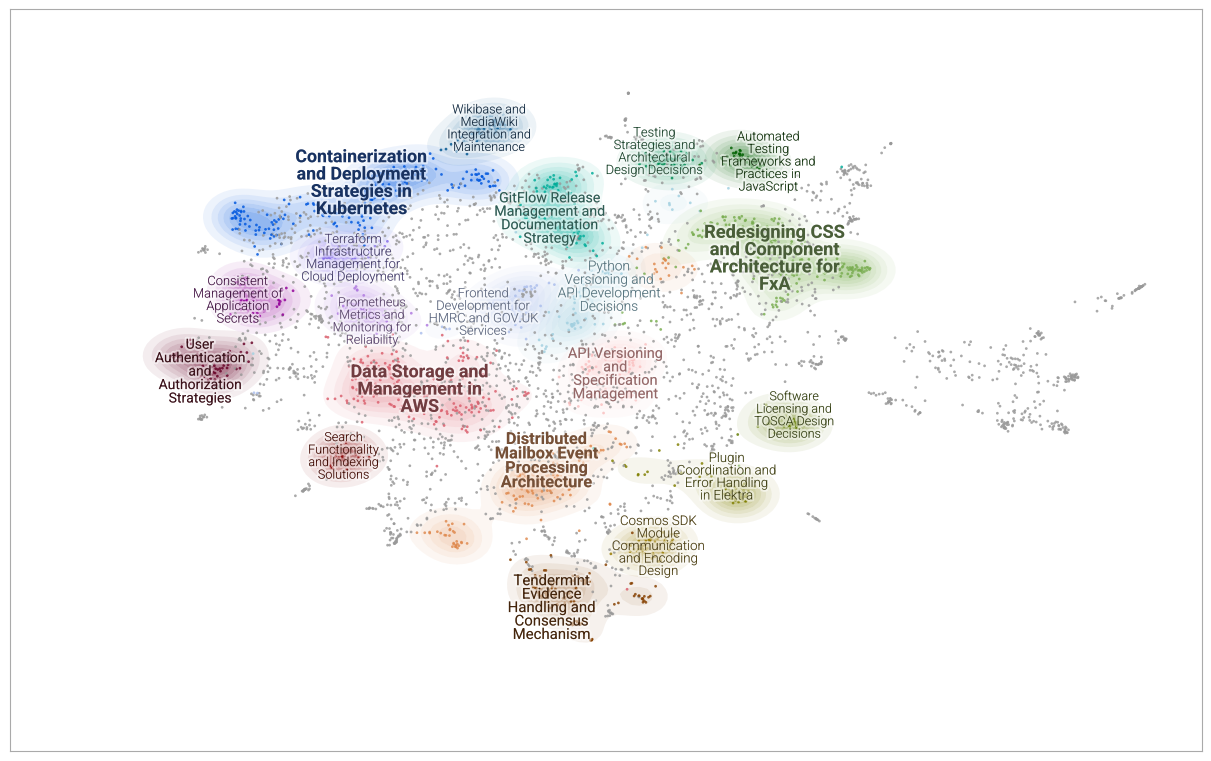

In [ ]:
# Note: the specific topics to be shown can be selected and passed as arguments (e.g., topics=[0,1,2])
first_20_topics = list(range(-1,20))
fig = topic_model.visualize_document_datamap(corpus, embeddings=embeddings, custom_labels=True, topic_prefix=True, topics=first_20_topics,
                                       title=None, #"Top-20 Topics in ADRs (ADRs: {} - Topics: {})".format(n_adrs, n_topics), 
                                       datamap_kwds={"label_over_points": True,  
                                                     #"label_font_size": 11,
                                                     "dynamic_label_size": True, "max_font_size": 18, "min_font_size": 9
                                                     })

In [ ]:
# It works only if the number of topics is not too high
topic_model.visualize_document_datamap(corpus, embeddings=embeddings, interactive=True, custom_labels=True, topics=first_20_topics,
                                       topic_prefix=True, enable_search=True, title="Top-20 Topics in ADRs") 

### Visualization of Topics

In [ ]:
fig = topic_model.visualize_topics(custom_labels=True, title="Topic Mapping (Top 20 Topics)", top_n_topics=20) 
fig

In [48]:
topic_model.visualize_barchart(custom_labels=False, top_n_topics=20, title="Top 20 Topics in ADRs") # It can be saved as a PNG file

In [49]:
topic_model.visualize_heatmap() # Topic similarity

In [50]:
# Get the document-topic probabilities
topic_distribution, _ = topic_model.approximate_distribution(corpus)

100%|██████████| 5/5 [00:07<00:00,  1.57s/it]


### Hierarchies

In [56]:
topic_model.visualize_hierarchy(custom_labels=False) # Topic hierarchy

### World Cloud

In [68]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def create_wordcloud(model, topic):
    text = {word: value for word, value in model.get_topic(topic)}
    wc = WordCloud(background_color="white", max_words=1000)
    wc.generate_from_frequencies(text)
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

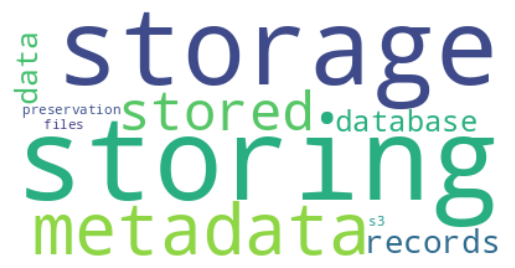

In [69]:
# Show wordcloud
create_wordcloud(topic_model, topic=1)

---
### Metrics

In [ ]:
def calculate_topic_coherence(model, top_n=10):
    topics = model.get_topics()
    if -1 in topics:
        del topics[-1]
    
    coherence_scores = []
    for topic_id in topics:
        words = [word for word, _ in topics[topic_id][:top_n]]
        embeddings = embedding_model.encode(words)
        
        # Compute pairwise cosine similarities
        sim_matrix = np.zeros((len(words), len(words)))
        for i in range(len(words)):
            for j in range(i+1, len(words)):
                sim = np.dot(embeddings[i], embeddings[j]) / (
                    np.linalg.norm(embeddings[i]) * np.linalg.norm(embeddings[j])
                )
                sim_matrix[i][j] = sim
        avg_sim = np.mean(sim_matrix[np.triu_indices(len(words), k=1)])
        coherence_scores.append(avg_sim) # Mean similarity for the topic
    
    return np.mean(coherence_scores) # Mean similarity for all topics

In [94]:
from itertools import combinations

def calculate_topic_diversity(model, top_n=10):
    # Exclude outlier topic (-1) if present
    topics = model.get_topics()
    if -1 in topics:
        del topics[-1]
    
    # Extract top words for each topic
    topic_words = [set([word for word, _ in topics[topic][:top_n]]) for topic in topics]
    
    # Compute pairwise Jaccard similarities
    jaccard_sims = []
    for t1, t2 in combinations(topic_words, 2):
        intersection = len(t1 & t2)
        union = len(t1 | t2)
        jaccard_sim = intersection / union if union != 0 else 0
        jaccard_sims.append(jaccard_sim)
    
    # Average similarity and compute diversity
    avg_sim = sum(jaccard_sims) / len(jaccard_sims)
    diversity = 1 - avg_sim
    return diversity

In [95]:
# Topic coherence quantifies the semantic similarity among words within a topic. 
# A high coherence score indicates that the words in a topic are closely related and likely to appear together in documents
# Coherence scores typically range from 0 to 1, with 1 representing perfect coherence and 0 representing no coherence. 
# For instance, a good coherence score might be around 0.5 or higher

# Topic diversity measures how distinct or unique different topics are from each other. 
# A high diversity score suggests that the topics capture a wide range of different aspects of the corpus.


print("Coherence=", calculate_topic_coherence(topic_model))
print("Diversity=", calculate_topic_diversity(topic_model))

Coherence= 0.36464095826179543
Diversity= 0.9959942691350488
